# Project 3 Design Report - Redoing Project 1, on NSF Grant Termination

In [1]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

import string
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import circlify

### Audience & Intent:

The audience for this project is the everyday US citizen who wants to be informed at the actions and implications of the current government administration, or that is particularly worried about the state of research in the US. While I don't want to spell out or imply a motivation, I want to make it very clear what sort of programs are being targetted and get the audience to think further into what could be purpose of these actions. This is because I don't want to directly take a political stance that would turn away part of the audience, and by structuring the article with just facts and without answering my final question, I hope to engage the reader and get them to think more critically about the actions being taken.

### Story & Structure:

The story I am telling is, in its simplest form, that the Trump Administration is blocking research being done into the accessbility and education. I am writing the article in a factual way by showing my visuals and explaining what they're showing in the context of the NSF without offering conjecture as to the 'why' or 'how' in order to plainly show the actions being taken and what it is effecting. For this purpose, I organized my visuals to start with the broader picture and narrowing it down. I start with showing the sectors of the NSF that are most effected before digging more into the individual grants effected. First, I show the grant titles and look for patterns within these. Then in order to further cement the information from these titles, since they can sometimes be misleading, I look into patterns and word frequenct in the grant abstracts. By using this method, I hope that any of the audience that is skeptical at first is able to understnad the intentional patterns in the grants that have been terminated. Additionally, for this version of the project I tried to incorporate more interactive visuals in order to create more engagement.

# Dataset

Dataset Origin: [May 6th Tidy Tuesday Dataset-National Science Foundation Grant Terminations under the Trump Administration](https://github.com/rfordatascience/tidytuesday/blob/main/data/2025/2025-05-06/readme.md)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-05-06/nsf_terminations.csv')

Dataset size: 21 columns and 1041 rows of data

|variable                |class     |description                           |
|:-----------------------|:---------|:-------------------------------------|
|grant_number            |character |The numeric ID of the grant. |
|project_title           |character |The title of the project the grant funds. |
|termination_letter_date |date      |The date a termination letter was received by the organization. |
|org_name                |character |The name of the organization or institution funded to do the project. |
|org_city                |character |The name of the organization's city. |
|org_state               |character |The organization's two-letter state abbreviation. |
|org_district            |character |The congressional district (state and number) where the organization is located. |
|usaspending_obligated   |double    |The amount of money, via USAspending.gov, that NSF had committed to funding. |
|award_type              |character |The type of grant. |
|directorate_abbrev      |character |The three-letter abbreviation of the NSF directorate name. |
|directorate             |character |The NSF directorate (the highest level of organization), which administered the grant. |
|division                |character |The NSF division (housed within directorate) which administered the grant. |
|nsf_program_name        |character |The name of the funding program under which the grant was made. |
|nsf_url                 |character |The URL pointing to the award information in the public NSF award database. |
|usaspending_url         |character |The URL pointing to budget and spending information at the public USAspending.gov website. |
|nsf_startdate           |date      |The start date of the project. |
|nsf_expected_end_date   |date      |The date the project was expected to end. |
|org_zip                 |character |The 5- or 9-digit ZIP code of the organization receiving the grant. |
|org_uei                 |character |The unique entitity identifier (UEI) of the organization recieving the grant, used across U.S. government databases. |
|abstract                |character |The text of the project abstract, describing the work to be done. |
|in_cruz_list            |logical   |Whether the project was in a [list of NSF projects named by U.S. Senator Ted Cruz](https://democrats-science.house.gov/imo/media/doc/democratic_staff_report-defending_hidden_figures.pdf) that he claimed "promoted Diversity, Equity, and Inclusion (DEI) or advanced neo-Marxist class warfare propaganda." |


# Pre-processing

In [3]:
df = df.dropna(subset=['directorate']).copy()

In [4]:
df['directorate'] = df['directorate'].str.replace('"Social, Behavioral and Economic Sciences"','Social, Behavioral, and Economic Sciences')
df['directorate'] = df['directorate'].str.replace('"Technology, Innovation and Partnerships"','Technology, Innovation, and Partnerships')
df['directorate'] = df['directorate'].str.replace('Computer and Information Science and Engineering','Computer & Info Science')

Making a function for colors so that I can make all the graphics have the same color scheme in order to make everything more cohesive.

In [6]:
# list of directorates
directorates = df['directorate'].unique()

palette = px.colors.qualitative.Plotly  

# Mapping the colors for consistency
directorate_color_map = {
    d: palette[i % len(palette)]
    for i, d in enumerate(directorates)
}

# Function to get color from map
def get_color(row):
    # if root (parent == ""), use its own id (the directorate)
    if row["parents"] == "":
        return directorate_color_map[row["ids"]]
    # otherwise, use the parent's color
    else:
        return directorate_color_map[row["parents"]]

# Sunburst Diagram - Cancelled Funds

In project 1, I used a pie chart for this. I had to break the largest directorate's data into its smaller divisions for more clarity. I had to make note of that outside of the graph in order to avoid confusion and exploded those sections to try and make the difference more obvious. The explosions were sloppy and make the graphic look less proffesional. Generally, I think the execution wasn't great, and that I could more clearly show the divisions of the directorates using a starburst pie chart. By using plotly, I was also able to make it interactive so that you could see more clearly the smaller sections by clicking into them. I also decided to hide the exact amount of money inside tooltips. This is because the amount of money isn't meant the focus, but rather the proportions of what specifically was targetted. I changed the name in order to be clearer on what the graph was showing.

In [7]:
# Formatting data for the diagram
directorate_sum = df.groupby('directorate', as_index=False)['usaspending_obligated'].sum()
division_sum = df.groupby(['directorate', 'division'], as_index=False)['usaspending_obligated'].sum()

sunburst_data = pd.concat([
    pd.DataFrame({
        'ids': directorate_sum['directorate'],
        'labels': directorate_sum['directorate'],
        'parents': [''] * len(directorate_sum),
        'values': directorate_sum['usaspending_obligated']
    }),
    pd.DataFrame({
        'ids': division_sum['directorate'] + " - " + division_sum['division'],
        'labels': division_sum['division'],
        'parents': division_sum['directorate'],
        'values': division_sum['usaspending_obligated']
    })
])

sunburst_data["color"] = sunburst_data.apply(get_color, axis=1)


# Making a function to wrap text so more labels are visible in the starburst
def wrap_label(text, width):
    words = text.split()
    lines = []
    current_line = ""

    for word in words:
        if len(current_line) + len(word) + 1 > width:
            lines.append(current_line)
            current_line = word
        else:
            current_line = word if current_line == "" else current_line + " " + word

    if current_line:
        lines.append(current_line)

    return "<br>".join(lines)

sunburst_data['labels'] = sunburst_data['labels'].apply(lambda x: wrap_label(x, 25))


In [8]:
fig = go.Figure(go.Sunburst(
    ids=sunburst_data['ids'],
    labels=sunburst_data['labels'],
    parents=sunburst_data['parents'],
    values=sunburst_data['values'],
    marker=dict(colors=sunburst_data["color"]),
    branchvalues='total',
    hovertemplate="<b>%{label}</b><br>$%{value:,.2f}<extra></extra>",
    insidetextorientation='radial'
))


fig.update_layout(
    title=dict(
        text="<b>Cancelled Funds by NSF Directorates</b>",
        font=dict(size=32, color='white', family='Arial'),
        x=0.5,
    ),
    uniformtext=dict(minsize=13, mode='hide'),
    margin=dict(t=80, l=0, r=0, b=0),
    height=900,
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color='white')
)


fig.show()
fig.write_html("project3/fig_1.html")

Resources:

- [poltly sunburst charts](https://plotly.com/python/sunburst-charts/)
- [Guide On How To Plot Sunburst Charts in Plotly](https://pub.towardsai.net/let-the-sunburst-the-complete-guide-on-how-to-plot-sunburst-charts-in-plotly-ef0eadfede83)

# Tree Map - Grant Titles

I used a near identical tree map in project 1, because I believe that it was a great way to show word frequency. The biggest issues I had with it last time were with text size, which I am hoping to fix by embedding a larger, interactive version of the map into my final post in order to make the text more readable. Another change I made was making sure that the color scheme of the sunburst chart matches that of this chart so that directorates maintain the same color scheme, making the visuals more cohesive.

## NLP

Tokenizing the titles

In [9]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# lowercase and tokenize the titles
def tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    return tokens

df["tokens"] = df["project_title"].apply(tokenize)

Resources:

- [Tokenization in NLP : All you need to know](https://medium.com/@abdallahashraf90x/tokenization-in-nlp-all-you-need-to-know-45c00cfa2df7)
- [Cleaning and Preprocessing Text Data in Pandas for NLP Tasks](https://www.kdnuggets.com/cleaning-and-preprocessing-text-data-in-pandas-for-nlp-tasks)

## Tree map

In [10]:
# Removing tokens that are related to the directorates or research in general, as those ore obvious and provide little insight
remove_words = {
    "collaborative", "research", "stem", "engineering", "grant",
    "social", "behavioral", "economic", "science", "computing",
    "sciences", "biology", "geosciences", "geoscience", "education"
}

# Define custom number tokens per directorate for directorates that take up less/more of the total
top_n_per_dir = {
    'STEM Education': 10, # Since this category makes up over 50% of the data
}

# Find top tokens per directorate
top_tokens_by_dir = {}
for d, group in df.groupby("directorate"):
    all_tokens = [
        tok
        for tokens in group['tokens']
        for tok in tokens
        if tok not in remove_words
    ]
    counter = Counter(all_tokens)
    n = top_n_per_dir.get(d, 5)  # default 5 unless overridden
    top_tokens_by_dir[d] = [w for w, _ in counter.most_common(n)]

# Keep only rows that contain top tokens
def get_top_tokens(row):
    d = row['directorate']
    return [tok for tok in row['tokens'] if tok in top_tokens_by_dir[d]]

df['selected_tokens'] = df.apply(get_top_tokens, axis=1)

# Explode so each row has one token and all can be considered
df_exploded = df.explode("selected_tokens")

# Count all the tokens
counts = df_exploded.groupby(
    ["directorate", "selected_tokens"]
).size().reset_index(name="count")

# Format tokens so they are all caps for readabiloty, wrap the word if its too long
counts["wrapped_label"] = counts["selected_tokens"].apply(
    lambda x: f"<span style='hyphens:auto; word-wrap:break-word;'>{x.upper()}</span>" if x else ""
)

# Wrap the very long directorate names into two lines + make them bold
def wrap_directorate(name):
    mapping = {
        "Social, Behavioral, and Economic Sciences": "Social, Behavioral,<br>and Economic Sciences",
        "Technology, Innovation, and Partnerships": "Technology, Innovation<br>and Partnerships",
        "Computer and Information Science and Engineering": "Computer and Information<br>Science and Engineering",
        "Mathematical and Physical Sciences": "Mathematical<br>and Physical Sciences"
    }
    wrapped = mapping.get(name, name)
    return f"<b>{wrapped}</b>"   # make bold


counts["directorate_wrapped"] = counts["directorate"].apply(wrap_directorate)

In [11]:
fig = px.treemap(
    counts,
    path=["directorate_wrapped", "wrapped_label"],
    values="count",
    color="directorate",   # <<< use plain name for color consistency
    color_discrete_map=directorate_color_map,
    title="<b>Most Common Terminated Grant Title Words per NSF Directorate</b>"
)

fig.update_traces(
    texttemplate="<b>%{label}<br>%{value}</b>",
    textinfo="label+value",
    textfont_size=14
)

# directorates
fig.update_traces(selector=dict(level=0), textfont_size=20)
# tokens
fig.update_traces(selector=dict(level=1), textfont_size=14)

# borders + text color
fig.update_traces(
    marker=dict(line=dict(width=2, color="white")),
    textfont=dict(color="white")
)

# custom tooltip
fig.update_traces(
    hovertemplate="<b>%{label}</b>: %{value} counts<extra></extra>"
)

fig.update_layout(
    width=1550,
    height=900,
    title_font=dict(size=32, family="Arial", color="white"),
    title={'x':0.5, 'xanchor': 'center'},
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color='white'),
    margin=dict(t=80, l=25, r=20, b=0),
)


fig.show()
fig.write_html("project3/fig_2.html")

# Bubble Chart - Abstract Frequency

In project 1, I used a word cloud to show abstract frequency. I think that this was too cluttered, and that the color scheme I had selected make it hard to read. It also made it hard to view what words exactly were more common than others, and it was hard to know what to focus on since there was so much text. For this reason, I decided to swap graphs entirely and use a bubble chart instead. I tilted the labels in order to make it readable, along with tooltips to know the exact count. I made sure to space the points as far as possible to make it more readable as well.

## NLP

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Turn abstracts into ngrams (2–3 words)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
X = vectorizer.fit_transform(df['abstract'].astype(str))
terms = vectorizer.get_feature_names_out()

# Sum counts for each n-gram (X is sparse → efficient)
total_counts = X.sum(axis=0).A1   # A1 gives a flat array

# Build a DataFrame directly
df_words = pd.DataFrame({
    "words": terms,
    "count": total_counts
}).sort_values("count", ascending=False)

# Get top N
TOP_N = 40
df_top = df_words.head(TOP_N).reset_index(drop=True)

Resources:

- [Mastering sklearn CountVectorizer: A Comprehensive Guide](https://www.pythontutorials.net/blog/sklearn-countvectorizer/)
- [Using CountVectorizer for NLP feature extraction](https://www.ibm.com/reference/python/countvectorizer)

## Bubble

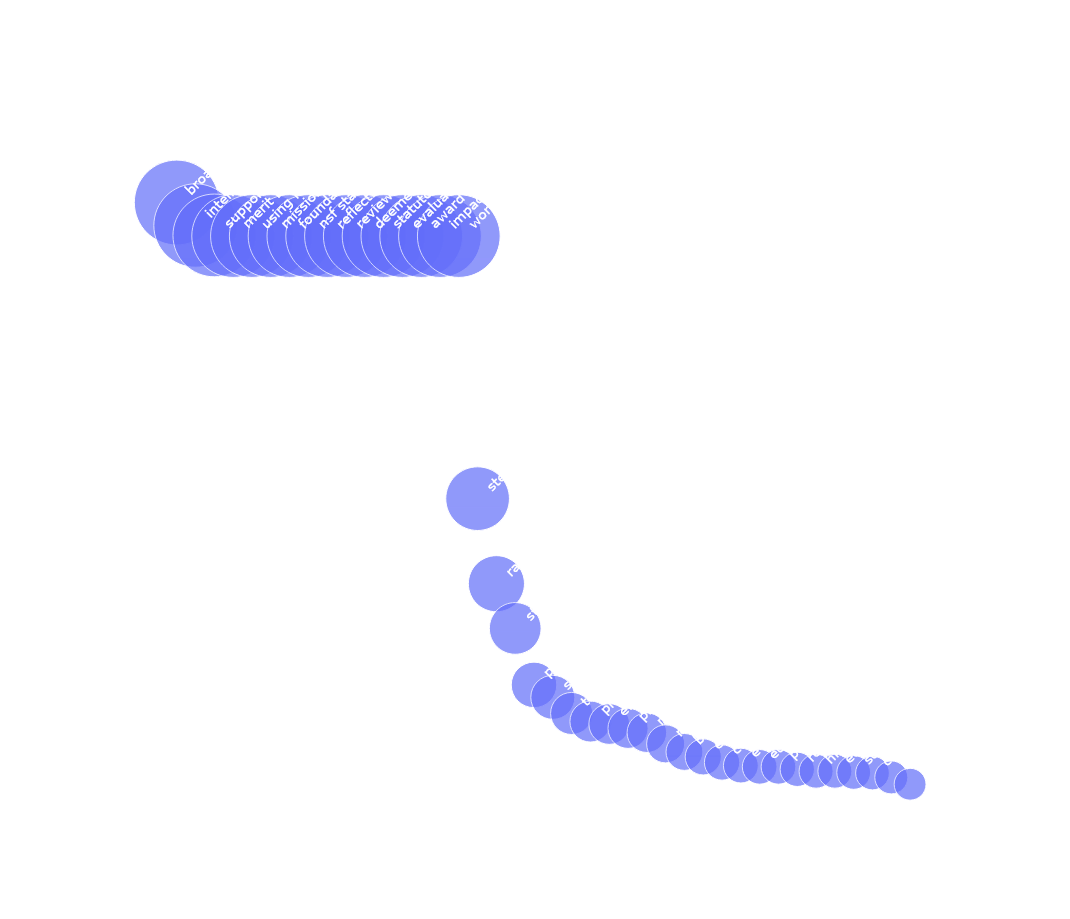

In [13]:
fig = px.scatter(
    df_top,
    x="words",
    y="count",
    size="count",
    size_max=60,
    title="<b>Top 40 Phrases in Terminated Grant Theses</b>",
)

# Remove default text
fig.update_traces(text=None)

# Add tilted annotations for each bubble so theyre readable
for i, row in df_top.iterrows():
    fig.add_annotation(
        x=row['words'],
        y=row['count'],
        text=row['words'],
        showarrow=False,
        font=dict(color="white", size=14),
        xanchor="left",
        yanchor="bottom",
        textangle=-45
    )

fig.update_layout(
    width=1500,           
    height=900,
    xaxis=dict(
        title="",
        showticklabels=False,   
        showgrid=False,       
        zeroline=False     
    ),
    yaxis=dict(
        title=dict(
            text="<b>Frequency</b>",
            font=dict(size=20)
        ),
        tickfont=dict(size=16),
        showgrid=True,
        gridcolor='rgba(255,255,255,0.2)',
        zeroline=False,
        tickmode='array',               
        tickvals=[200, 400, 600, 800, 1000, 1200],  
        ticktext=["200", "400", "600", "800", "1000", "1200"]
    ),
    title_font=dict(size=32, family="Arial", color="white"),
    title={'x':0.5, 'xanchor': 'center'},
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color="white")
)


fig.show()
fig.write_html("project3/fig_3.html")

Resources:

- [Plotly Bubble Charts](https://plotly.com/python/bubble-charts/)

# Reflection

Generally, I think I succeeded in improving project 1. At first, it was a struggle to decide what approach would be the best for how to change the visualizations I made. I felt like the small changes I could make (increasing text size and spacing) didn't necessitate a whole new version, so I pivoted for a while on making a dashboard instead with the data. As I went through the process of drawing up drafts, I realized that the loss of control in the narrative was a major drawback for the message I was trying to portray to the audience, and went back to this approach. 

At this point I started seriously considering making all my visuals in plotly in order to add some increased level of interaction with the reader. Additionally, this would allow for zooming in and clicking into data which would also improve the readability. The treemap I made for project 1 was already done in plotly, and I thought it held up well, albeit with text readability issues with size. I fixed those as best as I could and looked at the other two graphs. I looked through plotly's library of graphs to see if there was any better graphs I could use for my visualizations, which is how I found the sunburst and bubble charts. They fundamentally show the same data, but in a much more organized way, which I thought was a major bonus. 

Other decisions I think worked well were:
- Using the same font, the readability is the best with this one, and gives a more serious impression than others.
- Increasing text size, make text more readable where possible.
- Making graphics larger, allows you to take in the data much easier.
- Matching the color scheme for directorate for cohesive design

The biggest challenge came when I had completed all the charts and moved to embed the interactive versions into my wordpress portfolio. I assumed this would be a simple enough html or iframe embedding, but I quickly learnt that wordpress does not support either for plotly diagrams. I thought about swapping back to static photos, but as the majority of my improvements hinged on the increased interactivity, I decided to post this on github pages instead. It has been my goal for the past few months to eventually pivot all my portfolio posts onto github since I think it is a stronger display of my skills, but due to the limited timeframe I hsd at the moment, I used a very slapdash approach of copying html from my wordpress website for the time being. This created a lot of issues with the page itself outside of the specific scope of the project so I tried my best to get it viable before submission. 

While technically "outside the scope" of this project, I believe that the hodgepodge nature of the webpage does negatively effect the quality of the project as a whole, and with more time this is the biggest thing I want to improve. Outside of this, I stuck with the same color scheme as I did for project 1 since I didn't have any glaring issues with it, but I think a more focused color pallete would benefit the project as a whole, as well as maybe make it more readable (less neon colors).